### EDA Goals
1. Dist. of customers impacted by outage start (sum of max of each region per outage)
1. Dist. of outages by region
1. Dist. of duration of outages
1. Dist. of (final) cause of outages

If time:
1. Transition matrix of initial to final outages


In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = './merged_data.pkl'
with open(pickle_file, 'rb') as f:
    df = pickle.load(f)

In [3]:
select_cols = [True for i in range(len(df.columns))]

In [4]:
select_cols[df.columns.tolist().index('regionName')] = False
select_cols[df.columns.tolist().index('cause')] = False
select_cols[df.columns.tolist().index('crewCurrentStatus')] = False

In [5]:
df = df.loc[:,select_cols]

### Drop duplicate rows

In [6]:
df.columns

Index(['id', 'outage', 'snapshot', 'lastUpdateTime', 'currentEtor', 'autoEtor',
       'estCustAffected', 'hazardFlag', 'latitude', 'longitude', 'when',
       'cause', 'crewCurrentStatus', 'regionName'],
      dtype='object')

In [7]:
len(df)

4185492

In [8]:
exclude = ['id', 'snapshot', 'when']
dup_cols = df.columns.tolist()
for col in exclude:
    dup_cols.remove(col)

In [9]:
dup_cols

['outage',
 'lastUpdateTime',
 'currentEtor',
 'autoEtor',
 'estCustAffected',
 'hazardFlag',
 'latitude',
 'longitude',
 'cause',
 'crewCurrentStatus',
 'regionName']

In [10]:
len(df.drop_duplicates(dup_cols))

537577

In [11]:
df = df.drop_duplicates(dup_cols)

### Filter for weather outages

In [12]:
weather_cause = 'Our preliminary determination is that your outage was caused by the weather.'
fire_cause = 'To protect public safety, power in your area has been turned off due to extreme weather conditions with high fire danger. Power will be restored as soon as it is safe to do so.'
df = df[(df['cause'] == weather_cause) | (df['cause'] == fire_cause)]

In [13]:
len(df)

77193

### Start and end times

In [14]:
unique_key = ['outage', 'regionName']
outage_start_df = df.sort_values('snapshot').groupby(unique_key).first()#[['when']]
outage_end_df = df.sort_values('snapshot').groupby(unique_key).last()#[['when']]

In [15]:
unique_key = ['outage', 'regionName']
outage_start = outage_start_df[['when']]
outage_end = outage_end_df[['when']]

In [16]:
len(outage_start)

10117

In [17]:
len(df[unique_key].drop_duplicates())

10117

In [18]:
sample_row = df.dropna(subset=['currentEtor']).sample(1)

In [19]:
sample_row.values

array([['1570812624:649976', 649976, 17194,
        Timestamp('2019-10-11 11:40:08'),
        Timestamp('2019-10-14 01:00:00'), nan, 983, 0, 38.76117,
        -120.5582, Timestamp('2019-10-11 11:50:24'),
        'To protect public safety, power in your area has been turned off due to extreme weather conditions with high fire danger. Power will be restored as soon as it is safe to do so.',
        'PG&E has assigned a crew to assess the outage.',
        'Pollock Pines']], dtype=object)

In [20]:
list(df.sample(1).items())

[('id', 337327    1572233437:685713
  Name: id, dtype: object), ('outage', 337327    685713
  Name: outage, dtype: int64), ('snapshot', 337327    19470
  Name: snapshot, dtype: int64), ('lastUpdateTime',
  337327   2019-10-27 22:11:36
  Name: lastUpdateTime, dtype: datetime64[ns]), ('currentEtor', 337327   NaT
  Name: currentEtor, dtype: datetime64[ns]), ('autoEtor', 337327   NaN
  Name: autoEtor, dtype: float64), ('estCustAffected', 337327    613
  Name: estCustAffected, dtype: int64), ('hazardFlag', 337327    0
  Name: hazardFlag, dtype: int64), ('latitude', 337327    37.81952
  Name: latitude, dtype: float64), ('longitude', 337327   -122.20686
  Name: longitude, dtype: float64), ('when', 337327   2019-10-27 22:30:37
  Name: when, dtype: datetime64[ns]), ('cause',
  337327    To protect public safety, power in your area h...
  Name: cause, dtype: object), ('crewCurrentStatus',
  337327    PG&E has assigned a crew to assess the outage.
  Name: crewCurrentStatus, dtype: object), ('regi

In [21]:
assert(len(outage_start) == len(df[unique_key].drop_duplicates()))
assert(len(outage_end) == len(df[unique_key].drop_duplicates()))

In [22]:
outage_start.head()

,,when
outage,regionName,
404024,Milpitas,2019-06-10 23:15:02
404096,San Jose,2019-06-10 23:15:02
404159,San Jose,2019-06-10 23:15:02
404166,San Jose,2019-06-10 23:15:02
404180,San Jose,2019-06-10 23:15:02


In [23]:
outage_end.head()

,,when
outage,regionName,
404024,Milpitas,2019-06-11 09:10:51
404096,San Jose,2019-06-11 10:00:56
404159,San Jose,2019-06-10 23:15:02
404166,San Jose,2019-06-11 14:10:22
404180,San Jose,2019-06-10 23:15:02


### EDA goals
1. want to get a column of duration per outage (plot dist)
1. outage duration at every point in time
1. time to estimated repair
1. time to actual repair
1. error in estimate at every timestep

1. want to get a column of duration per outage (plot dist)

In [24]:
outage_duration_df = outage_end.reset_index().merge(outage_start.reset_index(),on=unique_key, suffixes=('_end', '_start'))

In [25]:
outage_duration_hrs = ((outage_duration_df['when_end'] - outage_duration_df['when_start']).apply(lambda x: x.total_seconds()) / (60*60)).to_frame()

In [26]:
outage_duration_hrs.describe()

,0
count,10117.000000
mean,29.094799
std,26.574160
min,0.000000
25%,5.164722
50%,23.334722
75%,42.370278
max,170.001111


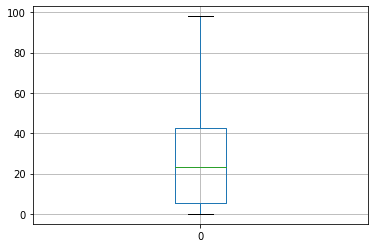

In [27]:
outage_duration_hrs.boxplot(0,showfliers=False)

2. outage duration at every point in time

In [28]:
df = df.merge(outage_start.reset_index(), on=unique_key, suffixes=('','_start_time'))

In [29]:
df['outage_duration_hrs'] = (df['when'] - df['when_start_time']).apply(lambda x: x.total_seconds()) / (60*60)

In [30]:
df[['outage_duration_hrs']].describe()

,outage_duration_hrs
count,77193.000000
mean,25.716175
std,25.495123
min,0.000000
25%,3.499167
50%,18.668333
75%,39.003333
max,170.001111


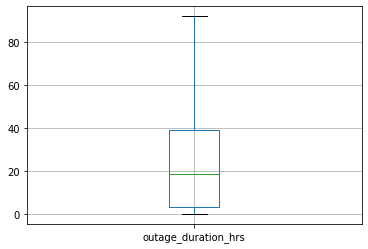

In [31]:
df.boxplot('outage_duration_hrs',showfliers=False)

3. time to estimated repair

In [32]:
df.columns

Index(['id', 'outage', 'snapshot', 'lastUpdateTime', 'currentEtor', 'autoEtor',
       'estCustAffected', 'hazardFlag', 'latitude', 'longitude', 'when',
       'cause', 'crewCurrentStatus', 'regionName', 'when_start_time',
       'outage_duration_hrs'],
      dtype='object')

In [33]:
df['time_to_est_repair_hrs'] = (df['currentEtor'] - df['when']).apply(lambda x: x.total_seconds()) / (60*60)

In [34]:
df[['time_to_est_repair_hrs']].describe()

,time_to_est_repair_hrs
count,20208.000000
mean,26.619059
std,24.097158
min,-14.341111
25%,6.488472
50%,22.823333
75%,32.655278
max,105.492222


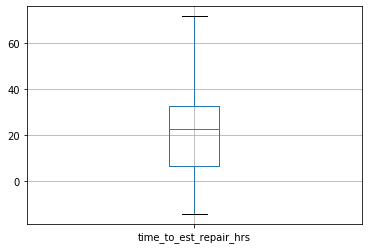

In [35]:
df.boxplot('time_to_est_repair_hrs',showfliers=False)

3a. time to estimated repair when the prediction is made

4. time to actual repair

In [36]:
df = df.merge(outage_end.reset_index(), on=unique_key, suffixes=('','_end_time'))

In [37]:
df['time_to_repair_hrs'] = (df['when_end_time'] - df['when']).apply(lambda x: x.total_seconds()) / (60*60)

In [38]:
df[['time_to_repair_hrs']].describe()

,time_to_repair_hrs
count,77193.000000
mean,17.893540
std,20.464368
min,0.000000
25%,1.829722
50%,10.004722
75%,26.835278
max,170.001111


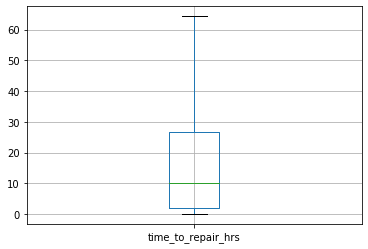

In [39]:
df.boxplot('time_to_repair_hrs',showfliers=False)

5. error in estimate at every timestep

In [40]:
df['est_repair_error_hrs'] = (df['when_end_time'] - df['currentEtor']).apply(lambda x: x.total_seconds()) / (60*60)

In [41]:
df[['est_repair_error_hrs']].describe()

,est_repair_error_hrs
count,20208.000000
mean,-19.066794
std,24.556827
min,-103.655278
25%,-28.490556
50%,-9.491667
75%,-3.162778
max,122.175000


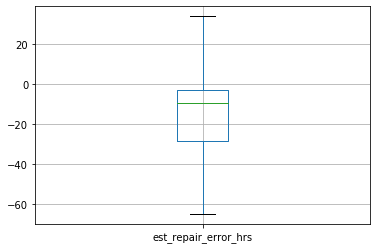

In [42]:
df.boxplot('est_repair_error_hrs',showfliers=False)

6. Correlation between duration and prediction accuracy

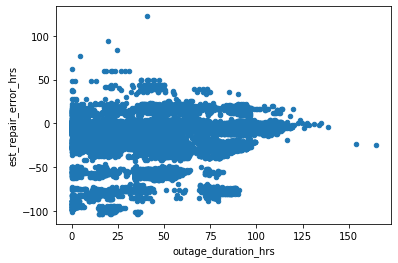

In [43]:
df.plot.scatter(x='outage_duration_hrs', y='est_repair_error_hrs')

### Dist. of outages by region

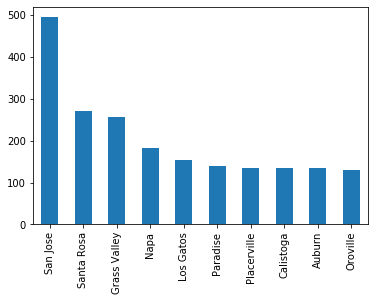

In [44]:
outages_by_region = df.sort_values('snapshot').drop_duplicates(unique_key, keep='first')
outages_by_region['regionName'].value_counts()[:10].plot(kind='bar')

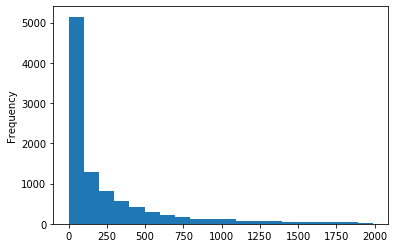

In [45]:
outages_by_region[outages_by_region['estCustAffected']<2000]['estCustAffected'].plot(kind='hist',bins=20)

In [46]:
thresh = 5
customers_affected = len(outages_by_region[outages_by_region['estCustAffected']<thresh])
pct_affected = round((customers_affected / len(outages_by_region))*100,2)
print('Pct. of outages with {} or fewer customers affected: {}%'.format(thresh, pct_affected))

Pct. of outages with 5 or fewer customers affected: 19.29%


### Drill into one particular outage that was a result of weather

In [47]:
# sample_outage = weather_df.sample(1)['outage'].iloc[0]

# sample_outage

# weather_df[weather_df['outage'] == sample_outage].sort_values(by='snapshot')

In [48]:
len(df)

77193

In [49]:
last_entry_df = df.sort_values('snapshot').groupby(unique_key).last()

In [50]:
total_unique_weather_outages = len(last_entry_df)

In [51]:
unique_weather_outages_w_est_df = last_entry_df.dropna(subset=['currentEtor'])

In [52]:
unique_weather_outages_w_est = len(unique_weather_outages_w_est_df)

In [53]:
frac_w_est = unique_weather_outages_w_est / total_unique_weather_outages
frac_wo_est = round((1-frac_w_est)*100,2)
print('Pct. of outages missing a forecast: {}%'.format(frac_wo_est))

Pct. of outages missing a forecast: 44.31%


In [54]:
unique_weather_outages_wo_est_df = last_entry_df[last_entry_df['currentEtor'].isna()]

In [55]:
unique_weather_outages_wo_est_df['outage_duration_hrs'].describe()

count    4483.000000
mean       15.686362
std        17.841352
min         0.000000
25%         0.337361
50%         6.001667
75%        33.113889
max        88.342222
Name: outage_duration_hrs, dtype: float64

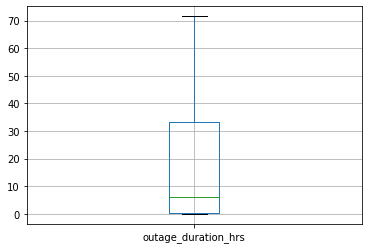

In [56]:
unique_weather_outages_wo_est_df.boxplot('outage_duration_hrs', showfliers=False)

In [57]:
# customers who didn't know when their power would come back on
unique_weather_outages_wo_est_df['estCustAffected'].sum()

1070984

In [58]:
unique_weather_outages_wo_est_df['estCustAffected'].describe()

count    4483.000000
mean      238.898952
std       498.878246
min         0.000000
25%         1.000000
50%        46.000000
75%       252.000000
max      5519.000000
Name: estCustAffected, dtype: float64

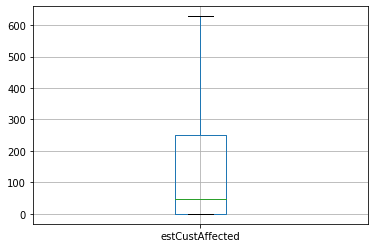

In [59]:
unique_weather_outages_wo_est_df.boxplot('estCustAffected', showfliers=False)

In [60]:
# time span
print('Oldest entry: {}'.format(last_entry_df['when_start_time'].min()))
print('Most recent entry: {}'.format(last_entry_df['when_end_time'].max()))

Oldest entry: 2019-06-10 23:15:02
Most recent entry: 2019-12-08 22:30:39


In [61]:
last_entry_df['day'] = last_entry_df['when_start_time'].apply(lambda x: x.date())

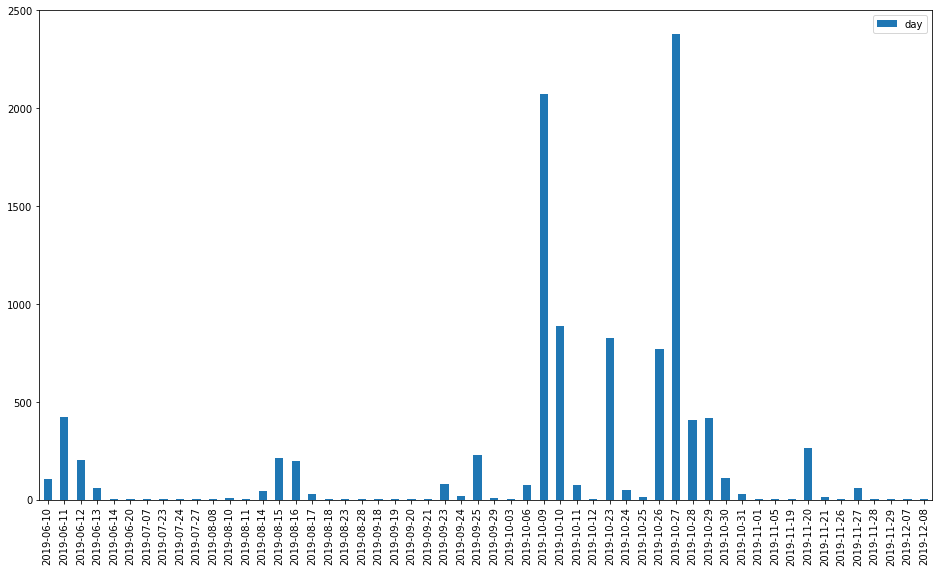

In [62]:
last_entry_df['day'].value_counts().to_frame().sort_index().plot(kind='bar',figsize=(16,9))

### Evaluate RMSE of PG&E predictions

In [63]:
rmse = unique_weather_outages_w_est_df['est_repair_error_hrs'].apply(lambda x: x ** 2).mean() ** .5

In [64]:
rmse

34.68824771019581

### Save results

In [65]:
last_entry_df = last_entry_df.reset_index()
# last_entry_df.to_csv('weather_outages_log.csv',index=False)

In [66]:
pickle_file = './weather_outages_log.pkl'
with open(pickle_file, 'wb') as f:
    pickle.dump(last_entry_df, f)